In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score

# Read and load dataset
ds = pd.read_csv('/kaggle/input/tweet-data/train.csv',encoding = 'UTF-8')
ds.head(5)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
#Columns or features of the dataset
ds.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [3]:
#Drop any null values present in the text column in the dataset

ds['text'].dropna(inplace =True)
print(np.sum(ds['text'].isnull()))

0


In [4]:
print(np.sum(ds['target'].isnull()))

0


In [5]:
# Number of unique values present in the target column 
print("Unique values in target variable ","\n",ds['target'].unique())

print(ds['target'].value_counts())

Unique values in target variable  
 [1 0]
target
0    4342
1    3271
Name: count, dtype: int64


<Axes: xlabel='target', ylabel='count'>

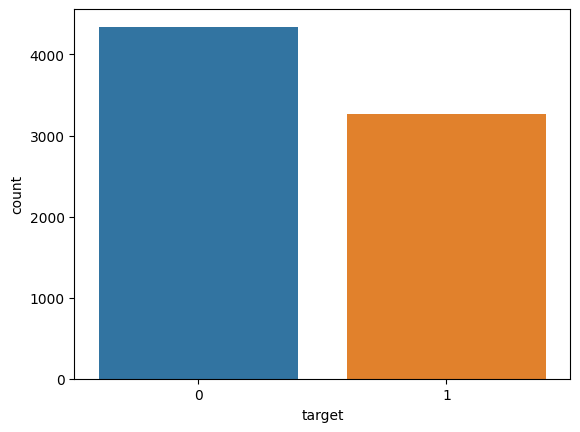

In [6]:
# Data visualization of the target variable

sns.countplot(ds,x = 'target')

In [7]:
df = ds.copy()

# Preprocessing of text data

In [8]:
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') 


english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def remove_URL(text):
    """Remove URLs from a text string"""
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)   

def remove_stopwords(sen):
    stop_words = set(stopwords.words('english'))
    word = sen.lower().split()
    filtered_sentence =[w for w in word if w not in stop_words]
    data = " ".join(filtered_sentence)
    return data

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Remove any url's present in the text data
df['text'] = df['text'].apply(lambda x :remove_URL(x))

# Remove numbers present in the text data
df['text'] = df['text'].apply(lambda x:cleaning_numbers(x))

# Remove stopwords in the text data 
df['text'] = df['text'].apply(lambda x:remove_stopwords(x))

# Remove punctuations present in the data
df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x))

In [10]:

df.iloc[5:7607]

,id,keyword,location,text,target
5,8,NaN,NaN,rockyfire update california hwy closed direct...,1
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1
7,13,NaN,NaN,im top hill see fire woods,1
8,14,NaN,NaN,theres emergency evacuation happening building...,1
9,15,NaN,NaN,im afraid tornado coming area,1
...,...,...,...,...,...
7602,10860,NaN,NaN,siren went forney tornado warning,1
7603,10862,NaN,NaN,officials say quarantine place alabama home po...,1
7604,10863,NaN,NaN,worldnews fallen powerlines glink tram update ...,1
7605,10864,NaN,NaN,flip side im walmart bomb everyone evacuate st...,1


In [11]:
from sklearn.model_selection import train_test_split

# split the data into train and test data
x = df['text']
y = df['target']
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.2,shuffle =True,random_state = 1024)


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
max_length = max([len(xin) for xin in x ])
token = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x_train)
pad_seq = pad_sequences(seq,maxlen=max_length,padding ='post',truncating ='post')
t_seq = token.texts_to_sequences(x_val)
val_pad_seq = pad_sequences(t_seq,maxlen=max_length,padding ='post',truncating ='post')
vocab_size = len(token.word_index)+1

In [13]:
np.random.seed(seed = 1000)

# Define model
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,100,input_length = max_length),
#tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(75,dropout = 0.4,return_sequences = True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout = 0.4,return_sequences = True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,dropout = 0.4)),
tf.keras.layers.Dense(8,activation = 'relu'),
#tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(1,activation = 'sigmoid')
])
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss='binary_crossentropy',metrics = ['accuracy'])
history = model.fit(pad_seq,y_train,epochs = 100,batch_size=128,validation_data=(val_pad_seq,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 138, 100)          1752200   
                                                                 
 bidirectional (Bidirection  (None, 138, 150)          105600    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 138, 64)           46848     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                        

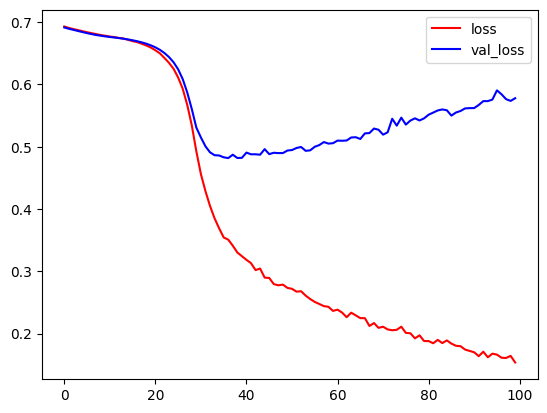

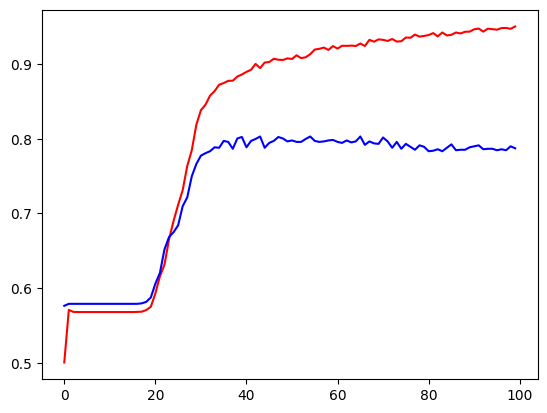

In [14]:
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.legend(['loss','val_loss'])
plt.show()
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')

In [15]:
y_pred = (model.predict(pad_seq)> 0.5).astype("int32")
#y_predicted = np.argmax(y_pred,axis =-1)
y_val_pred = (model.predict(val_pad_seq)> 0.5).astype("int32")

48/48 [==============================] - 1s 15ms/step


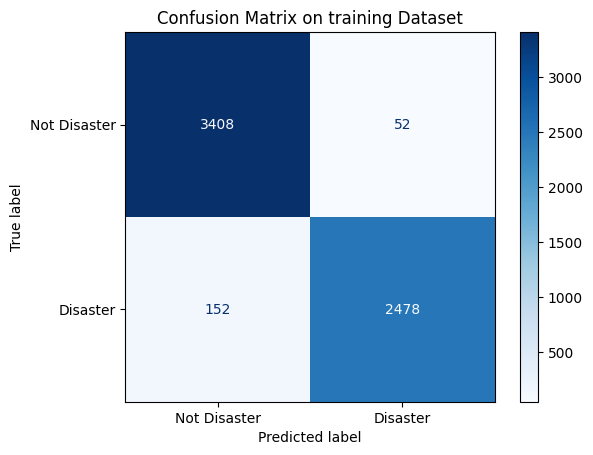

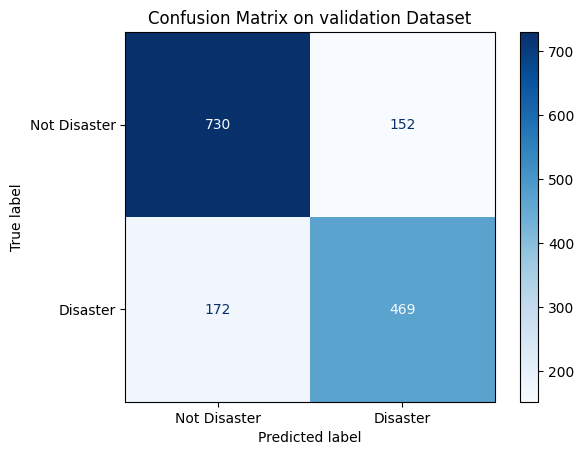

In [16]:

def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues)
    
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset")
displayConfusionMatrix(y_train,y_pred,'training')
plt.show()
displayConfusionMatrix(y_val,y_val_pred,'validation')

In [17]:
# Finding accuracy and f1 score of training data
print("Accuracy and F1 score of training data: \n")
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy   :", accuracy)
f1 = f1_score(y_train,y_pred)
print("f1_score :\n",f1)

# Finding accuracy and f1 score of testing data
print("\n Accuracy and F1 score of validation data: \n")
accuracy_test = accuracy_score(y_val, y_val_pred)
print("Accuracy   :", accuracy_test)
f1_test = f1_score(y_val,y_val_pred)
print("f1_score :",f1_test)

Accuracy and F1 score of training data: 

Accuracy   : 0.9665024630541872
f1_score :
 0.9604651162790698

 Accuracy and F1 score of validation data: 

Accuracy   : 0.7872619829284307
f1_score : 0.7432646592709984


# Evaluation on test dataset

In [18]:
df_test = pd.read_csv('/kaggle/input/tweet-data/test.csv')
x_test = df_test['text']

test_sen = token.texts_to_sequences(x_test)
pad_test = pad_sequences(test_sen,maxlen =max_length,padding ='post',truncating ='post')

In [21]:
y_p = (model.predict(pad_test)>0.5).astype("int32")
df_test['predicted'] = y_p
final = df_test.copy()
final = final.drop(['keyword','location','text'],axis ='columns')
final.head(20)

,id,predicted
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [22]:
final.to_csv('final_submission.csv',index =False)